In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 percent More buy CNN Images Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  lab

In [6]:
r_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  la

## Train Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


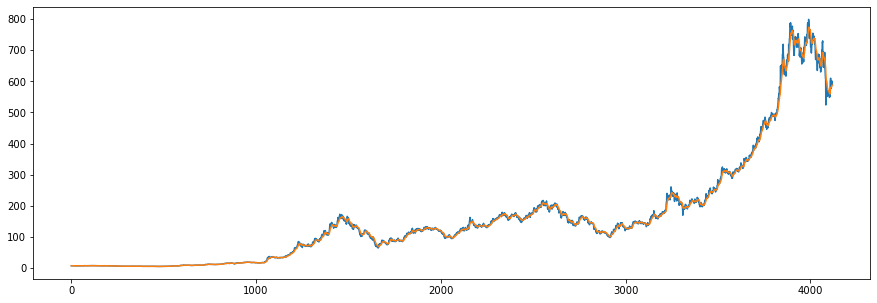

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


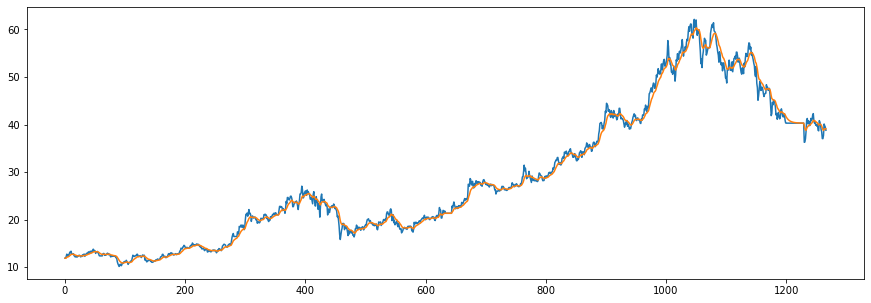

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


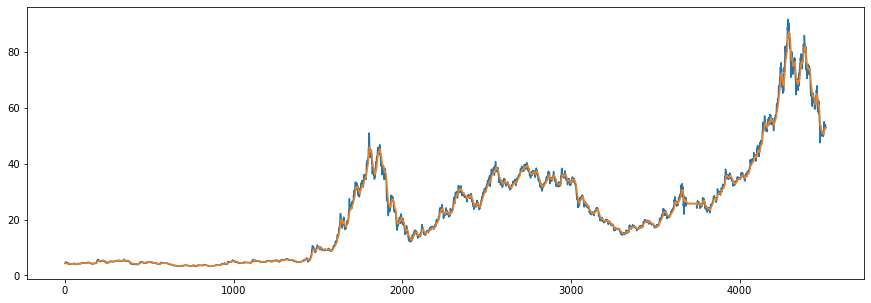

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


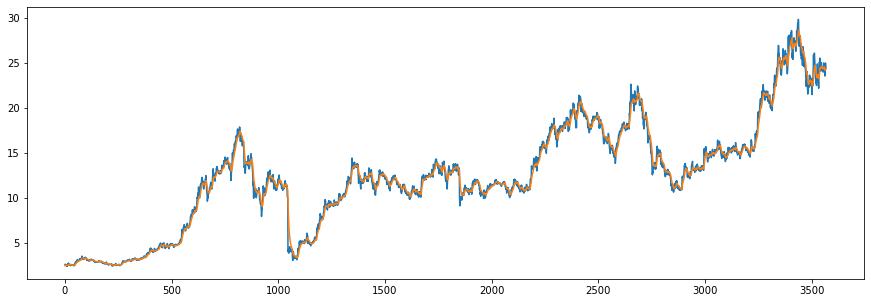

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      50.0000  47.379245 -27.700831  21139400.0     2.0
2000-01-24      48.5000  47.551669 -40.997230  17619200.0     2.0
2000-01-25      47.0000  47.466797 -54.293629  12613700.0     2.0
2000-01-26      49.6875  47.808444 -30.470914  16344500.0     2.0
2000-01-27      50.4375  48.212914 -27.215190  20127300.0     2.0


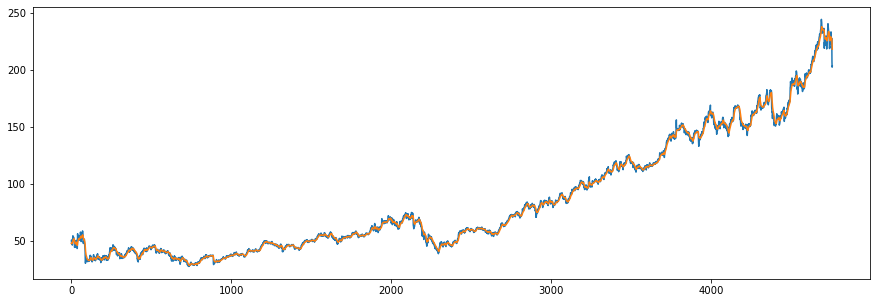

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21     56.28125  56.412106 -36.614173 -25968400.0     2.0
2000-01-24     51.34375  55.632359 -83.112583 -50347200.0     2.0
2000-01-25     51.56250  55.006226 -64.721485 -21792600.0     1.0
2000-01-26     48.75000  54.043730 -88.594164 -38890400.0     2.0
2000-01-27     50.31250  53.469695 -75.331565 -28647200.0     2.0


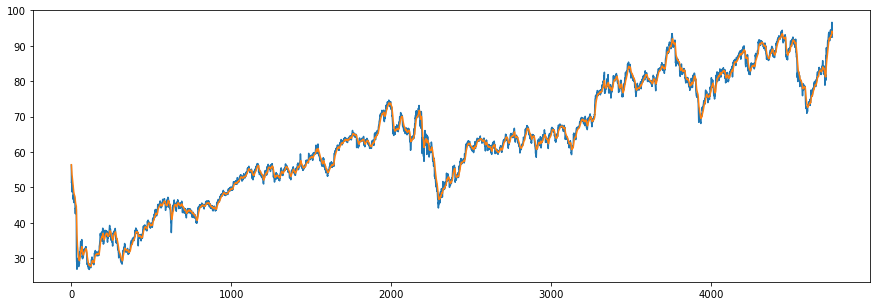

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


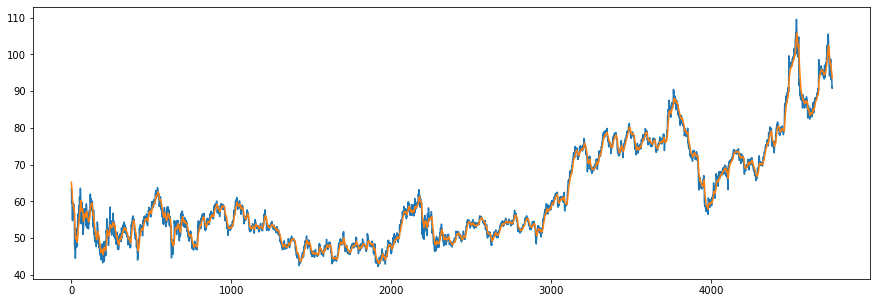

In [10]:
sequential_data = []
labels = []

train_sets = ['600519.SS','000333.SZ','000858.SZ','2319.HK','COST','PG','WMT']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1
            
    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
        
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()

In [11]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(27645, 64, 64, 1)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 25128, 1.0: 1252, 0.0: 1265})

In [13]:
X = sequential_data
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:939]
class_1 = class_1[0:1252]
class_2 = class_2[0:939]

class_0_labels = class_0_labels[0:939]
class_1_labels = class_1_labels[0:1252]
class_2_labels = class_2_labels[0:939]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

print(X.shape)

Counter(y)

(3130, 64, 64, 1)


Counter({0.0: 939, 1.0: 1252, 2.0: 939})

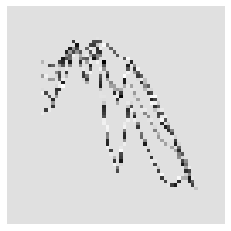

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600519.SS','000333.SZ','WMT','FDP']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[0 1 1 ... 1 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 1.1114070128717266, 1: 0.8330006653359947, 2: 1.1114070128717266}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/20 [>.............................] - ETA: 0s - loss: 0.4628 - accuracy: 0.2969 - mse: 6.1054 - weighted_accuracy: 0.3159 - weighted_mse: 6.0695WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
20/20 [==============================] - 1s 30ms/step - loss: 0.2468 - accuracy: 0.3431 - mse: 1.7817 - weighted_accuracy: 0.3396 - weighted_mse: 1.7751 - val_loss: 0.2031 - val_accuracy: 0.3962 - val_mse: 0.8286 - val_weighted_accuracy: 0.3962 - val_weighted_mse: 0.8286
Epoch 2/20
20/20 [==============================] - 0s 10ms/step - loss: 0.2052 - accuracy: 0.3678 - mse: 1.1868 - weighted_accuracy: 0.3476 - weighted_mse: 1.1935 - val_loss: 0.1945

7/7 [==============================] - 0s 5ms/step - loss: 0.2001 - accuracy: 0.1202 - mse: 1.0019 - weighted_accuracy: 0.1202 - weighted_mse: 1.0019
Test loss: 0.20006854832172394
Test accuracy: 0.12019230425357819


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 82
actual holds but predicted sell: 97
actual predicted holds: 10
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 5.825242718446602%
Percentage holds correct: 83.33333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 47.31182795698925%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 66.66666666666667%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase fr

7/7 [==============================] - 0s 2ms/step - loss: 0.2014 - accuracy: 0.0962 - mse: 1.0209 - weighted_accuracy: 0.0962 - weighted_mse: 1.0209
Test loss: 0.20142239332199097
Test accuracy: 0.09615384787321091


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 2
actual sells but predicted hold: 1
actual holds but predicted buy: 86
actual holds but predicted sell: 96
actual predicted holds: 11
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 2.0408163265306123%
Percentage holds correct: 91.66666666666667%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 47.95918367346939%
Percentage high sells correct: 49.48453608247423%
Percentage mid holds correct: 91.66666666666667%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Pri

Cash capital at the moment: $195.4698388475574


Share price: $0.8014674902031642
Shares owned at the moment: 243
Cash capital at the moment: $0.1776580778602579


Price increase from previously bought: 4.042044710093995%
Share price: $0.8361562881964029
Shares owned at the moment: 0
Cash capital at the moment: $202.80487466999892


Share price: $0.8198087601748079
Shares owned at the moment: 246
Cash capital at the moment: $0.5773190407379332


Price increase from previously bought: 2.6359174568708843%
Share price: $0.8437321425638047
Shares owned at the moment: 0
Cash capital at the moment: $207.56464131698945


Share price: $0.8640671544854943
Shares owned at the moment: 239
Cash capital at the moment: $0.4846832576707243


Price increase from previously bought: 2.8550122131799194%
Share price: $0.8911804023136407
Shares owned at the moment: 0
Cash capital at the moment: $212.89107109121022


Share price: $0.804258546411843
Shares owned at the moment: 263
Cash capital at the moment:

2         255.731682  


FDP


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.1284 - mse: 1.0085 - weighted_accuracy: 0.1284 - weighted_mse: 1.0085
Test loss: 0.19827602803707123
Test accuracy: 0.12844036519527435


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 106
actual holds but predicted sell: 78
actual predicted holds: 14
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 36.52173913043478%
Percentage high sells correct: 41.86046511627907%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: 




RUNNING EPOCHS 20 - 40



Epoch 1/20
20/20 [==============================] - 1s 27ms/step - loss: 0.1916 - accuracy: 0.4557 - mse: 1.2253 - weighted_accuracy: 0.4440 - weighted_mse: 1.2299 - val_loss: 0.1830 - val_accuracy: 0.5575 - val_mse: 0.9527 - val_weighted_accuracy: 0.5575 - val_weighted_mse: 0.9527
Epoch 2/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1901 - accuracy: 0.4665 - mse: 1.2269 - weighted_accuracy: 0.4507 - weighted_mse: 1.2292 - val_loss: 0.1788 - val_accuracy: 0.5399 - val_mse: 1.0861 - val_weighted_accuracy: 0.5399 - val_weighted_mse: 1.0861
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1891 - accuracy: 0.5008 - mse: 1.2331 - weighted_accuracy: 0.4862 - weighted_mse: 1.2390 - val_loss: 0.1781 - val_accuracy: 0.5479 - val_mse: 1.1083 - val_weighted_accuracy: 0.5479 - val_weighted_mse: 1.1083
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1903 - accuracy: 0.4800 - mse: 1.2636 - weighte

0        1666.892281  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.1058 - mse: 1.1967 - weighted_accuracy: 0.1058 - weighted_mse: 1.1967
Test loss: 0.19848452508449554
Test accuracy: 0.10576923191547394


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 64
actual holds but predicted sell: 119
actual predicted holds: 6
Percentage buys correct: 10.95890410958904%
Percentage sells correct: 6.299212598425197%
Percentage holds correct: 75.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.794520547945204%
Percentage high sells correct: 51.968503937007874%
Percentage mid holds correct: 57.142857142857146%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the momen

7/7 [==============================] - 0s 2ms/step - loss: 0.2010 - accuracy: 0.0865 - mse: 1.2376 - weighted_accuracy: 0.0865 - weighted_mse: 1.2376
Test loss: 0.2010415643453598
Test accuracy: 0.08653846383094788


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 79
actual holds but predicted sell: 108
actual predicted holds: 6
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 5.217391304347826%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 52.87356321839081%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previousl

7/7 [==============================] - 0s 2ms/step - loss: 0.1984 - accuracy: 0.0868 - mse: 1.2004 - weighted_accuracy: 0.0868 - weighted_mse: 1.2004
Test loss: 0.19842852652072906
Test accuracy: 0.08675798773765564


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 113
actual holds but predicted sell: 82
actual predicted holds: 6
Percentage buys correct: 4.918032786885246%
Percentage sells correct: 7.777777777777778%
Percentage holds correct: 85.71428571428571%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 49.586776859504134%
Percentage high sells correct: 45.55555555555556%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.2521008983715609
Shares owned at the moment: 395
Cash capital at the moment: $0.14630054237733248


Pric

3           5.320149  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.0913 - mse: 1.1920 - weighted_accuracy: 0.0913 - weighted_mse: 1.1920
Test loss: 0.198706716299057
Test accuracy: 0.09132420271635056


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 96
actual holds but predicted sell: 97
actual predicted holds: 6
Percentage buys correct: 6.60377358490566%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 75.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 49.523809523809526%
Percentage high sells correct: 48.57142857142857%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347

20/20 [==============================] - 0s 15ms/step - loss: 0.1757 - accuracy: 0.5651 - mse: 1.3394 - weighted_accuracy: 0.5417 - weighted_mse: 1.3472 - val_loss: 0.1676 - val_accuracy: 0.5927 - val_mse: 1.1483 - val_weighted_accuracy: 0.5927 - val_weighted_mse: 1.1483
Epoch 2/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1762 - accuracy: 0.5643 - mse: 1.3340 - weighted_accuracy: 0.5397 - weighted_mse: 1.3401 - val_loss: 0.1677 - val_accuracy: 0.5879 - val_mse: 1.1058 - val_weighted_accuracy: 0.5879 - val_weighted_mse: 1.1058
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1763 - accuracy: 0.5519 - mse: 1.3362 - weighted_accuracy: 0.5269 - weighted_mse: 1.3482 - val_loss: 0.1683 - val_accuracy: 0.5958 - val_mse: 1.1016 - val_weighted_accuracy: 0.5958 - val_weighted_mse: 1.1016
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 0.1746 - accuracy: 0.5691 - mse: 1.3681 - weighted_accuracy: 0.5458 - weighted_mse: 1.376

0        1666.892281  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2004 - accuracy: 0.1490 - mse: 1.2539 - weighted_accuracy: 0.1490 - weighted_mse: 1.2539
Test loss: 0.20041431486606598
Test accuracy: 0.14903846383094788


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 68
actual holds but predicted sell: 107
actual predicted holds: 14
Percentage buys correct: 11.538461538461538%
Percentage sells correct: 6.956521739130435%
Percentage holds correct: 93.33333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.246753246753244%
Percentage high sells correct: 52.17391304347826%
Percentage mid holds correct: 73.33333333333333%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital

1        1245.275482  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2055 - accuracy: 0.1154 - mse: 1.3082 - weighted_accuracy: 0.1154 - weighted_mse: 1.3082
Test loss: 0.2055182158946991
Test accuracy: 0.11538461595773697


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 88
actual holds but predicted sell: 92
actual predicted holds: 13
Percentage buys correct: 6.25%
Percentage sells correct: 5.1020408163265305%
Percentage holds correct: 92.85714285714286%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 55.10204081632653%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $

7/7 [==============================] - 0s 2ms/step - loss: 0.2014 - accuracy: 0.1055 - mse: 1.2727 - weighted_accuracy: 0.1055 - weighted_mse: 1.2727
Test loss: 0.20143745839595795
Test accuracy: 0.1055045872926712


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 94
actual holds but predicted sell: 98
actual predicted holds: 10
Percentage buys correct: 6.862745098039215%
Percentage sells correct: 5.769230769230769%
Percentage holds correct: 83.33333333333333%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 51.96078431372549%
Percentage high sells correct: 44.66019417475728%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase from

2         255.731682  


FDP


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1993 - accuracy: 0.1468 - mse: 1.2820 - weighted_accuracy: 0.1468 - weighted_mse: 1.2820
Test loss: 0.19930586218833923
Test accuracy: 0.14678898453712463


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 96
actual holds but predicted sell: 87
actual predicted holds: 15
Percentage buys correct: 8.49056603773585%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 43.80952380952381%
Percentage high sells correct: 45.833333333333336%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: 




RUNNING EPOCHS 60 - 80



Epoch 1/20
20/20 [==============================] - 0s 14ms/step - loss: 0.1665 - accuracy: 0.6070 - mse: 1.4085 - weighted_accuracy: 0.5813 - weighted_mse: 1.4191 - val_loss: 0.1638 - val_accuracy: 0.6054 - val_mse: 1.1468 - val_weighted_accuracy: 0.6054 - val_weighted_mse: 1.1468
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1644 - accuracy: 0.6174 - mse: 1.4282 - weighted_accuracy: 0.5917 - weighted_mse: 1.4368 - val_loss: 0.1631 - val_accuracy: 0.5831 - val_mse: 1.2216 - val_weighted_accuracy: 0.5831 - val_weighted_mse: 1.2216
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1657 - accuracy: 0.6130 - mse: 1.4103 - weighted_accuracy: 0.5875 - weighted_mse: 1.4186 - val_loss: 0.1632 - val_accuracy: 0.6102 - val_mse: 1.1890 - val_weighted_accuracy: 0.6102 - val_weighted_mse: 1.1890
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1655 - accuracy: 0.6006 - mse: 1.4452 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.2075 - accuracy: 0.1683 - mse: 1.3658 - weighted_accuracy: 0.1683 - weighted_mse: 1.3658
Test loss: 0.20753110945224762
Test accuracy: 0.16826923191547394


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 65
actual holds but predicted sell: 106
actual predicted holds: 18
Percentage buys correct: 12.0%
Percentage sells correct: 7.017543859649122%
Percentage holds correct: 94.73684210526316%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 56.75675675675676%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 73.6842105263158%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase f

7/7 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.1298 - mse: 1.4422 - weighted_accuracy: 0.1298 - weighted_mse: 1.4422
Test loss: 0.21539092063903809
Test accuracy: 0.12980769574642181


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 83
actual holds but predicted sell: 93
actual predicted holds: 17
Percentage buys correct: 6.593406593406593%
Percentage sells correct: 4.081632653061225%
Percentage holds correct: 89.47368421052632%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 56.12244897959184%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.1697 - mse: 1.3891 - weighted_accuracy: 0.1697 - weighted_mse: 1.3891
Test loss: 0.20829318463802338
Test accuracy: 0.16972477734088898


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 88
actual holds but predicted sell: 90
actual predicted holds: 24
Percentage buys correct: 7.291666666666667%
Percentage sells correct: 6.25%
Percentage holds correct: 92.3076923076923%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 53.125%
Percentage high sells correct: 45.26315789473684%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase from previously

2         255.731682  


FDP


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2052 - accuracy: 0.1835 - mse: 1.4022 - weighted_accuracy: 0.1835 - weighted_mse: 1.4022
Test loss: 0.20518693327903748
Test accuracy: 0.1834862381219864


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 90
actual holds but predicted sell: 85
actual predicted holds: 23
Percentage buys correct: 9.0%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 95.83333333333333%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 46.464646464646464%
Percentage high sells correct: 47.87234042553192%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.

3         -65.971313  



RUNNING EPOCHS 80 - 100



Epoch 1/20
20/20 [==============================] - 0s 14ms/step - loss: 0.1552 - accuracy: 0.6382 - mse: 1.4900 - weighted_accuracy: 0.6140 - weighted_mse: 1.4971 - val_loss: 0.1615 - val_accuracy: 0.5895 - val_mse: 1.4100 - val_weighted_accuracy: 0.5895 - val_weighted_mse: 1.4100
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1552 - accuracy: 0.6506 - mse: 1.4954 - weighted_accuracy: 0.6246 - weighted_mse: 1.5028 - val_loss: 0.1618 - val_accuracy: 0.5863 - val_mse: 1.4155 - val_weighted_accuracy: 0.5863 - val_weighted_mse: 1.4155
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1532 - accuracy: 0.6514 - mse: 1.5285 - weighted_accuracy: 0.6283 - weighted_mse: 1.5370 - val_loss: 0.1618 - val_accuracy: 0.5879 - val_mse: 1.3164 - val_weighted_accuracy: 0.5879 - val_weighted_mse: 1.3164
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1564 - accuracy: 0.6434 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.1827 - mse: 1.4736 - weighted_accuracy: 0.1827 - weighted_mse: 1.4736
Test loss: 0.21199704706668854
Test accuracy: 0.18269230425357819


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 62
actual holds but predicted sell: 105
actual predicted holds: 22
Percentage buys correct: 11.267605633802816%
Percentage sells correct: 7.079646017699115%
Percentage holds correct: 91.66666666666667%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 55.714285714285715%
Percentage high sells correct: 53.097345132743364%
Percentage mid holds correct: 70.83333333333333%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916



7/7 [==============================] - 0s 2ms/step - loss: 0.2232 - accuracy: 0.1250 - mse: 1.5768 - weighted_accuracy: 0.1250 - weighted_mse: 1.5768
Test loss: 0.22317515313625336
Test accuracy: 0.125


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 80
actual holds but predicted sell: 97
actual predicted holds: 16
Percentage buys correct: 6.818181818181818%
Percentage sells correct: 3.9215686274509802%
Percentage holds correct: 88.88888888888889%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.172413793103445%
Percentage high sells correct: 56.86274509803921%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase f

7/7 [==============================] - 0s 2ms/step - loss: 0.2142 - accuracy: 0.1651 - mse: 1.5136 - weighted_accuracy: 0.1651 - weighted_mse: 1.5136
Test loss: 0.2141665369272232
Test accuracy: 0.1651376187801361


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 86
actual holds but predicted sell: 92
actual predicted holds: 24
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 6.122448979591836%
Percentage holds correct: 88.88888888888889%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 52.68817204301075%
Percentage high sells correct: 45.36082474226804%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price i

7/7 [==============================] - 0s 2ms/step - loss: 0.2091 - accuracy: 0.2110 - mse: 1.5153 - weighted_accuracy: 0.2110 - weighted_mse: 1.5153
Test loss: 0.2091483324766159
Test accuracy: 0.2110091745853424


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 84
actual holds but predicted sell: 85
actual predicted holds: 29
Percentage buys correct: 9.574468085106384%
Percentage sells correct: 8.602150537634408%
Percentage holds correct: 93.54838709677419%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 46.236559139784944%
Percentage high sells correct: 47.31182795698925%
Percentage mid holds correct: 87.09677419354838%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price

Epoch 1/20
20/20 [==============================] - 0s 15ms/step - loss: 0.1443 - accuracy: 0.6981 - mse: 1.5670 - weighted_accuracy: 0.6781 - weighted_mse: 1.5763 - val_loss: 0.1640 - val_accuracy: 0.5607 - val_mse: 1.5089 - val_weighted_accuracy: 0.5607 - val_weighted_mse: 1.5089
Epoch 2/20
20/20 [==============================] - 0s 11ms/step - loss: 0.1445 - accuracy: 0.6897 - mse: 1.5914 - weighted_accuracy: 0.6690 - weighted_mse: 1.5978 - val_loss: 0.1652 - val_accuracy: 0.5511 - val_mse: 1.5706 - val_weighted_accuracy: 0.5511 - val_weighted_mse: 1.5706
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1427 - accuracy: 0.6921 - mse: 1.6793 - weighted_accuracy: 0.6706 - weighted_mse: 1.6878 - val_loss: 0.1628 - val_accuracy: 0.5895 - val_mse: 1.4487 - val_weighted_accuracy: 0.5895 - val_weighted_mse: 1.4487
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 0.1438 - accuracy: 0.6905 - mse: 1.6456 - weighted_accuracy: 0.6706 - weighted

Cash capital at the moment: $2801.1577775042556


Share price: $0.9093379914191821
Shares owned at the moment: 3071
Cash capital at the moment: $0.901219183914236


Price increase from previously bought: -5.203472839232292%
Share price: $0.8643913933179164
Shares owned at the moment: 0
Cash capital at the moment: $2648.1471866488173


Share price: $0.8722200584225899
Shares owned at the moment: 3027
Cash capital at the moment: $0.6764919823135642


Price increase from previously bought: -1.5211323878896899%
Share price: $0.8613145558209592
Shares owned at the moment: 0
Cash capital at the moment: $2600.705854761064




Capital at the end of test period: $2600.705854761064
profit gained: 2500.705854761064%


Capital at the end of test period if Buy and Hold: $1766.892280786996
profit gained: 1666.8922807869963%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.256039     12.987013       8.602151      94.594595   

   correct_low_buys  correct_high_sells  correct_

7/7 [==============================] - 0s 2ms/step - loss: 0.2134 - accuracy: 0.2705 - mse: 1.6811 - weighted_accuracy: 0.2705 - weighted_mse: 1.6811
Test loss: 0.2133861631155014
Test accuracy: 0.27053138613700867


number of predictions: 207
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 70
actual predicted holds: 39
Percentage buys correct: 10.344827586206897%
Percentage sells correct: 10.0%
Percentage holds correct: 97.5%
actual buys: 11
actual sells: 10
actual holds: 186


Percentage low buys correct: 57.47126436781609%
Percentage high sells correct: 58.75%
Percentage mid holds correct: 82.05128205128206%


Capital: 100
Share price: $0.02756851778230706
Shares owned at the moment: 3617
Cash capital at the moment: $0.01045402714420618


Price increase from previously bought: 4

7/7 [==============================] - 0s 3ms/step - loss: 0.2218 - accuracy: 0.2156 - mse: 1.6916 - weighted_accuracy: 0.2156 - weighted_mse: 1.6916
Test loss: 0.22176410257816315
Test accuracy: 0.21559633314609528


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 79
actual holds but predicted sell: 89
actual predicted holds: 34
Percentage buys correct: 8.045977011494253%
Percentage sells correct: 6.315789473684211%
Percentage holds correct: 94.44444444444444%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 56.32183908045977%
Percentage high sells correct: 45.744680851063826%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase f

7/7 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.2706 - mse: 1.6808 - weighted_accuracy: 0.2706 - weighted_mse: 1.6808
Test loss: 0.2122352421283722
Test accuracy: 0.2706421911716461


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 75
actual holds but predicted sell: 78
actual predicted holds: 45
Percentage buys correct: 7.317073170731708%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 47.5609756097561%
Percentage high sells correct: 47.674418604651166%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase from p




RUNNING EPOCHS 120 - 140



Epoch 1/20
20/20 [==============================] - 0s 14ms/step - loss: 0.1326 - accuracy: 0.7304 - mse: 1.7544 - weighted_accuracy: 0.7141 - weighted_mse: 1.7628 - val_loss: 0.1662 - val_accuracy: 0.5751 - val_mse: 1.4976 - val_weighted_accuracy: 0.5751 - val_weighted_mse: 1.4976
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1340 - accuracy: 0.7212 - mse: 1.7303 - weighted_accuracy: 0.7026 - weighted_mse: 1.7365 - val_loss: 0.1672 - val_accuracy: 0.5543 - val_mse: 1.5086 - val_weighted_accuracy: 0.5543 - val_weighted_mse: 1.5086
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1300 - accuracy: 0.7428 - mse: 1.7984 - weighted_accuracy: 0.7251 - weighted_mse: 1.8041 - val_loss: 0.1664 - val_accuracy: 0.5623 - val_mse: 1.5427 - val_weighted_accuracy: 0.5623 - val_weighted_mse: 1.5427
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1301 - accuracy: 0.7320 - mse: 1.8181 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.2305 - accuracy: 0.2260 - mse: 1.8260 - weighted_accuracy: 0.2260 - weighted_mse: 1.8260
Test loss: 0.23054859042167664
Test accuracy: 0.22596153616905212


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 57
actual holds but predicted sell: 100
actual predicted holds: 32
Percentage buys correct: 10.76923076923077%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 91.42857142857143%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 59.375%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previo

7/7 [==============================] - 0s 2ms/step - loss: 0.2514 - accuracy: 0.1635 - mse: 1.9825 - weighted_accuracy: 0.1635 - weighted_mse: 1.9825
Test loss: 0.2514495849609375
Test accuracy: 0.16346153616905212


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 70
actual holds but predicted sell: 99
actual predicted holds: 24
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 3.8461538461538463%
Percentage holds correct: 92.3076923076923%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.41025641025641%
Percentage high sells correct: 54.80769230769231%
Percentage mid holds correct: 92.0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase fr

7/7 [==============================] - 0s 2ms/step - loss: 0.2336 - accuracy: 0.2752 - mse: 1.8726 - weighted_accuracy: 0.2752 - weighted_mse: 1.8726
Test loss: 0.23361945152282715
Test accuracy: 0.2752293646335602


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 69
actual holds but predicted sell: 86
actual predicted holds: 47
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 6.521739130434782%
Percentage holds correct: 95.91836734693878%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 55.84415584415584%
Percentage high sells correct: 43.956043956043956%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.3211 - mse: 1.8595 - weighted_accuracy: 0.3211 - weighted_mse: 1.8595
Test loss: 0.22003678977489471
Test accuracy: 0.3211009204387665


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 63
actual holds but predicted sell: 79
actual predicted holds: 56
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 9.195402298850574%
Percentage holds correct: 91.80327868852459%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.57471264367816%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase from previously 




RUNNING EPOCHS 140 - 160



Epoch 1/20
20/20 [==============================] - 0s 15ms/step - loss: 0.1173 - accuracy: 0.7839 - mse: 1.9435 - weighted_accuracy: 0.7702 - weighted_mse: 1.9510 - val_loss: 0.1742 - val_accuracy: 0.5591 - val_mse: 1.7819 - val_weighted_accuracy: 0.5591 - val_weighted_mse: 1.7819
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.1163 - accuracy: 0.7764 - mse: 1.9994 - weighted_accuracy: 0.7613 - weighted_mse: 1.9997 - val_loss: 0.1759 - val_accuracy: 0.5495 - val_mse: 1.8900 - val_weighted_accuracy: 0.5495 - val_weighted_mse: 1.8900
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1177 - accuracy: 0.7704 - mse: 2.0186 - weighted_accuracy: 0.7561 - weighted_mse: 2.0210 - val_loss: 0.1768 - val_accuracy: 0.5607 - val_mse: 1.8481 - val_weighted_accuracy: 0.5607 - val_weighted_mse: 1.8481
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1161 - accuracy: 0.7804 - mse: 2.0510 - weight

0        1666.892281  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2426 - accuracy: 0.2837 - mse: 2.0799 - weighted_accuracy: 0.2837 - weighted_mse: 2.0799
Test loss: 0.2426293045282364
Test accuracy: 0.2836538553237915


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 58
actual holds but predicted sell: 86
actual predicted holds: 45
Percentage buys correct: 10.606060606060606%
Percentage sells correct: 7.526881720430108%
Percentage holds correct: 91.83673469387755%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.46153846153846%
Percentage high sells correct: 54.83870967741935%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at t

7/7 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.2356 - mse: 2.3198 - weighted_accuracy: 0.2356 - weighted_mse: 2.3198
Test loss: 0.2746024429798126
Test accuracy: 0.23557692766189575


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 68
actual holds but predicted sell: 85
actual predicted holds: 40
Percentage buys correct: 8.0%
Percentage sells correct: 3.3707865168539324%
Percentage holds correct: 90.9090909090909%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.0%
Percentage high sells correct: 57.30337078651685%
Percentage mid holds correct: 90.69767441860465%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously b

7/7 [==============================] - 0s 2ms/step - loss: 0.2495 - accuracy: 0.2890 - mse: 2.1579 - weighted_accuracy: 0.2890 - weighted_mse: 2.1579
Test loss: 0.24953991174697876
Test accuracy: 0.2889908254146576


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 72
actual holds but predicted sell: 80
actual predicted holds: 50
Percentage buys correct: 8.75%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 96.15384615384616%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 57.5%
Percentage high sells correct: 41.86046511627907%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase from previously bought: 305.9

7/7 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.3394 - mse: 2.1320 - weighted_accuracy: 0.3394 - weighted_mse: 2.1320
Test loss: 0.22731389105319977
Test accuracy: 0.33944955468177795


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 61
actual holds but predicted sell: 76
actual predicted holds: 61
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 8.433734939759036%
Percentage holds correct: 91.04477611940298%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 48.529411764705884%
Percentage high sells correct: 50.602409638554214%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Pr




RUNNING EPOCHS 160 - 180



Epoch 1/20
20/20 [==============================] - 0s 15ms/step - loss: 0.1035 - accuracy: 0.8139 - mse: 2.3005 - weighted_accuracy: 0.8039 - weighted_mse: 2.3013 - val_loss: 0.1866 - val_accuracy: 0.5575 - val_mse: 2.1390 - val_weighted_accuracy: 0.5575 - val_weighted_mse: 2.1390
Epoch 2/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1030 - accuracy: 0.8071 - mse: 2.3708 - weighted_accuracy: 0.7961 - weighted_mse: 2.3706 - val_loss: 0.1856 - val_accuracy: 0.5543 - val_mse: 2.0801 - val_weighted_accuracy: 0.5543 - val_weighted_mse: 2.0801
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1044 - accuracy: 0.8027 - mse: 2.3778 - weighted_accuracy: 0.7916 - weighted_mse: 2.3845 - val_loss: 0.1904 - val_accuracy: 0.5463 - val_mse: 2.2582 - val_weighted_accuracy: 0.5463 - val_weighted_mse: 2.2582
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 0.1028 - accuracy: 0.8027 - mse: 2.4038 - weigh

7/7 [==============================] - 0s 2ms/step - loss: 0.2560 - accuracy: 0.3317 - mse: 2.5969 - weighted_accuracy: 0.3317 - weighted_mse: 2.5969
Test loss: 0.2560405433177948
Test accuracy: 0.33173078298568726


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 49
actual holds but predicted sell: 84
actual predicted holds: 56
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 7.608695652173913%
Percentage holds correct: 93.33333333333333%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 61.81818181818182%
Percentage high sells correct: 54.34782608695652%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.2977 - accuracy: 0.3029 - mse: 2.9236 - weighted_accuracy: 0.3029 - weighted_mse: 2.9236
Test loss: 0.2976589500904083
Test accuracy: 0.30288460850715637


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 57
actual holds but predicted sell: 80
actual predicted holds: 56
Percentage buys correct: 6.557377049180328%
Percentage sells correct: 3.5714285714285716%
Percentage holds correct: 88.88888888888889%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 60.65573770491803%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 87.09677419354838%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Pri

Cash capital at the moment: $0.16263409528318107


Price increase from previously bought: -3.8289696176736276%
Share price: $0.21574175779046922
Shares owned at the moment: 0
Cash capital at the moment: $147.5393346455168


Share price: $0.24444993833819084
Shares owned at the moment: 601
Cash capital at the moment: $0.22090706867564336


Price increase from previously bought: -12.961970808921052%
Share price: $0.21334951081226206
Shares owned at the moment: 0
Cash capital at the moment: $128.09134966285018


Share price: $0.17347710542982786
Shares owned at the moment: 736
Cash capital at the moment: $0.06108240510690166


Price increase from previously bought: 35.482790616474055%
Share price: $0.23567796048168543
Shares owned at the moment: 0
Cash capital at the moment: $173.04304912761245


Share price: $0.24604487105776607
Shares owned at the moment: 701
Cash capital at the moment: $0.09128151593682787


Price increase from previously bought: 36.895742166509415%
Share price: $0.337

7/7 [==============================] - 0s 3ms/step - loss: 0.2309 - accuracy: 0.4266 - mse: 2.6313 - weighted_accuracy: 0.4266 - weighted_mse: 2.6313
Test loss: 0.2309410572052002
Test accuracy: 0.4266054928302765


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 46
actual holds but predicted sell: 70
actual predicted holds: 82
Percentage buys correct: 7.8431372549019605%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 91.11111111111111%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 52.94117647058823%
Percentage high sells correct: 49.35064935064935%
Percentage mid holds correct: 84.26966292134831%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price




RUNNING EPOCHS 180 - 200



Epoch 1/20
20/20 [==============================] - 0s 14ms/step - loss: 0.0937 - accuracy: 0.8331 - mse: 2.7956 - weighted_accuracy: 0.8233 - weighted_mse: 2.7790 - val_loss: 0.2034 - val_accuracy: 0.5447 - val_mse: 2.5256 - val_weighted_accuracy: 0.5447 - val_weighted_mse: 2.5256
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.0900 - accuracy: 0.8375 - mse: 2.8703 - weighted_accuracy: 0.8289 - weighted_mse: 2.8623 - val_loss: 0.2078 - val_accuracy: 0.5399 - val_mse: 2.6125 - val_weighted_accuracy: 0.5399 - val_weighted_mse: 2.6125
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.0855 - accuracy: 0.8530 - mse: 2.9192 - weighted_accuracy: 0.8456 - weighted_mse: 2.9061 - val_loss: 0.2127 - val_accuracy: 0.5415 - val_mse: 2.7533 - val_weighted_accuracy: 0.5415 - val_weighted_mse: 2.7533
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 0.0890 - accuracy: 0.8462 - mse: 2.9758 - weighte

7/7 [==============================] - 0s 2ms/step - loss: 0.3308 - accuracy: 0.2885 - mse: 3.1912 - weighted_accuracy: 0.2885 - weighted_mse: 3.1912
Test loss: 0.33082321286201477
Test accuracy: 0.2884615361690521


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 54
actual holds but predicted sell: 89
actual predicted holds: 46
Percentage buys correct: 11.290322580645162%
Percentage sells correct: 7.216494845360825%
Percentage holds correct: 93.87755102040816%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.65573770491803%
Percentage high sells correct: 53.608247422680414%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pr

7/7 [==============================] - 0s 2ms/step - loss: 0.3893 - accuracy: 0.1971 - mse: 3.6305 - weighted_accuracy: 0.1971 - weighted_mse: 3.6305
Test loss: 0.3892750144004822
Test accuracy: 0.19711539149284363


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 69
actual holds but predicted sell: 92
actual predicted holds: 32
Percentage buys correct: 8.0%
Percentage sells correct: 3.125%
Percentage holds correct: 86.48648648648648%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 57.333333333333336%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previousl

7/7 [==============================] - 0s 2ms/step - loss: 0.3416 - accuracy: 0.2936 - mse: 3.3200 - weighted_accuracy: 0.2936 - weighted_mse: 3.3200
Test loss: 0.34163898229599
Test accuracy: 0.29357796907424927


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 68
actual holds but predicted sell: 82
actual predicted holds: 52
Percentage buys correct: 8.0%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 94.54545454545455%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 54.666666666666664%
Percentage high sells correct: 41.37931034482759%
Percentage mid holds correct: 85.45454545454545%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase from p

2         255.731682  


FDP


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2896 - accuracy: 0.3578 - mse: 3.2071 - weighted_accuracy: 0.3578 - weighted_mse: 3.2071
Test loss: 0.28963929414749146
Test accuracy: 0.35779815912246704


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 59
actual holds but predicted sell: 74
actual predicted holds: 65
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.641975308641975%
Percentage holds correct: 91.54929577464789%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 48.484848484848484%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 84.28571428571429%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
C

In [21]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     8286.176638
1    11769.632820
2      162.762636
3       62.490746
Name: Profit gained, dtype: float64

In [22]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 

    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3])     

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


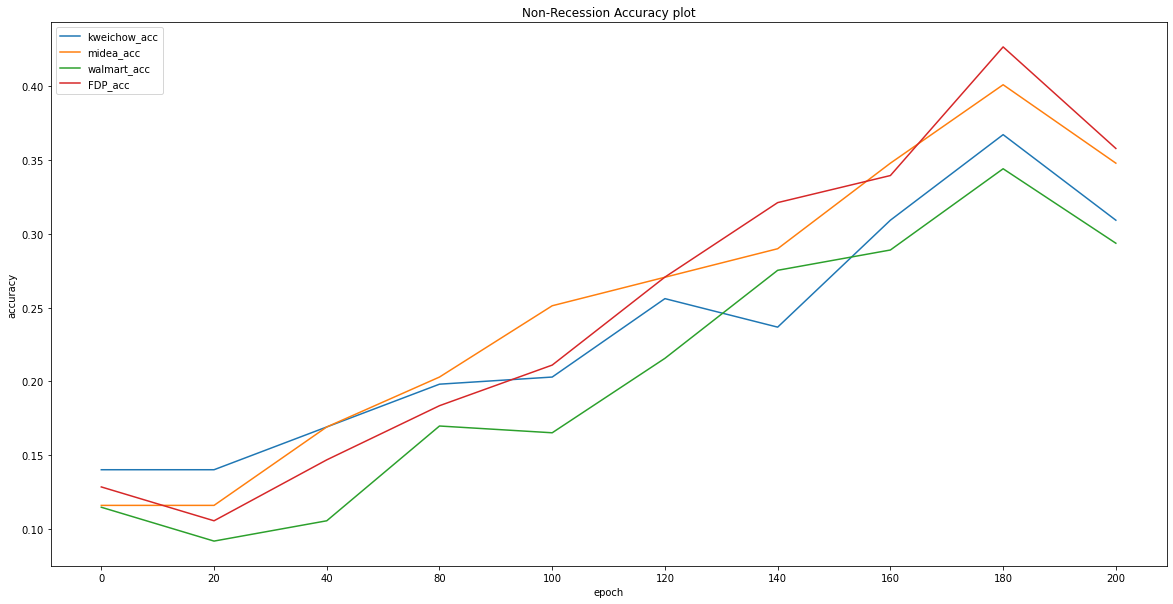

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

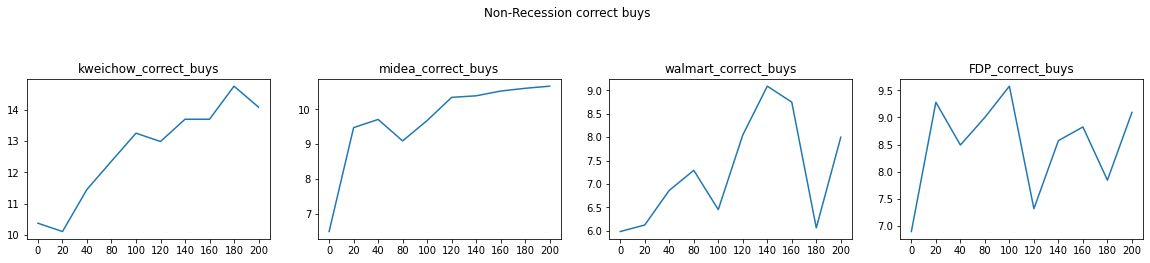

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")


Text(0.5, 1.0, 'FDP_correct_sells')

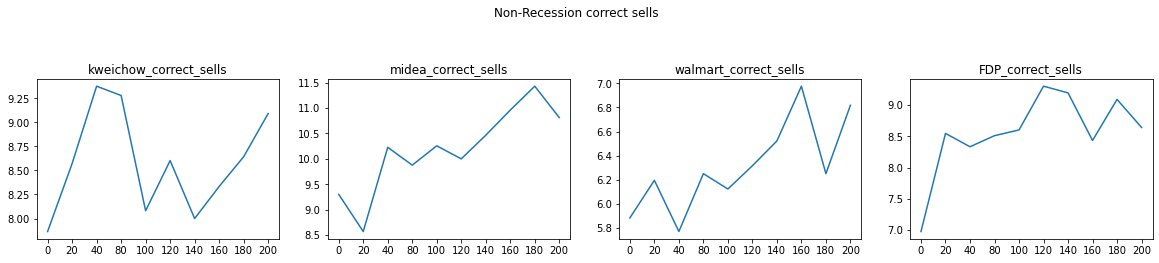

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

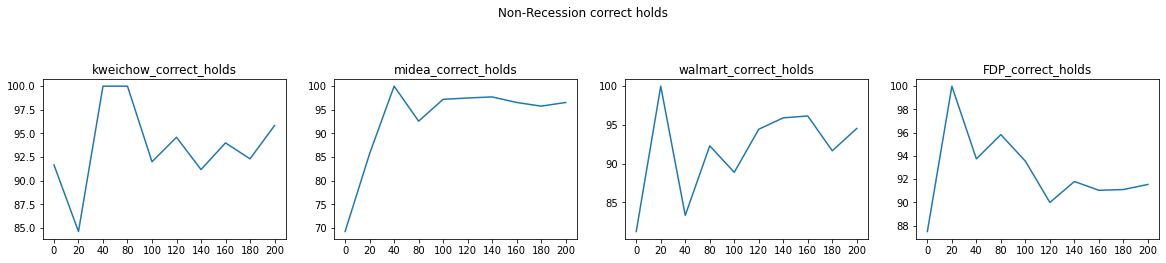

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

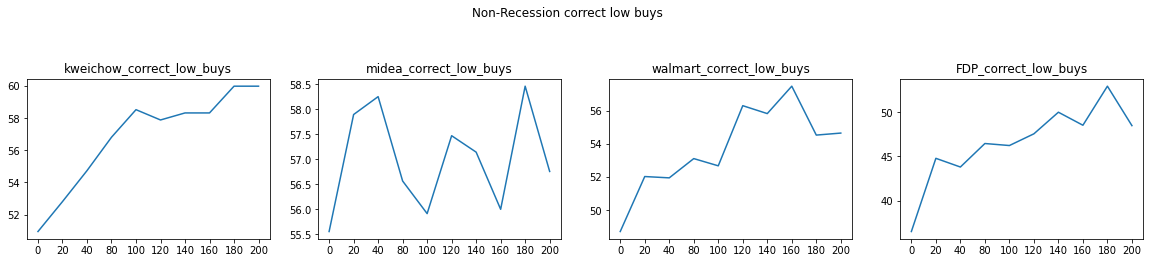

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

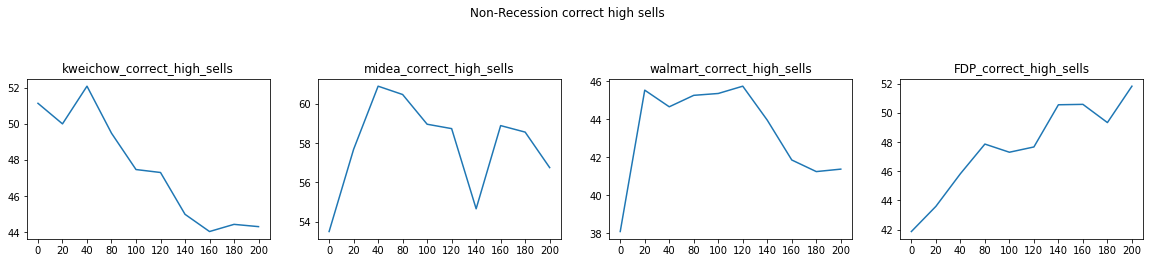

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

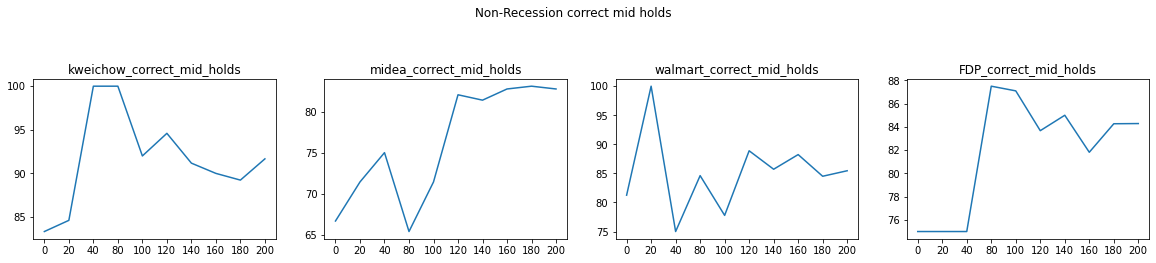

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

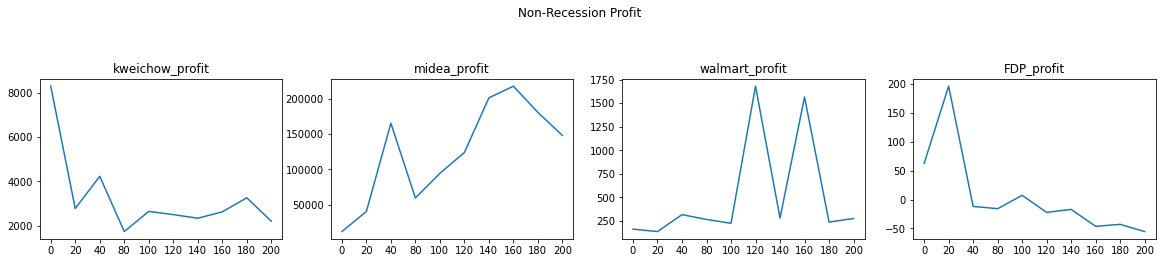

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")

In [31]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 
    
    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3]) 

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


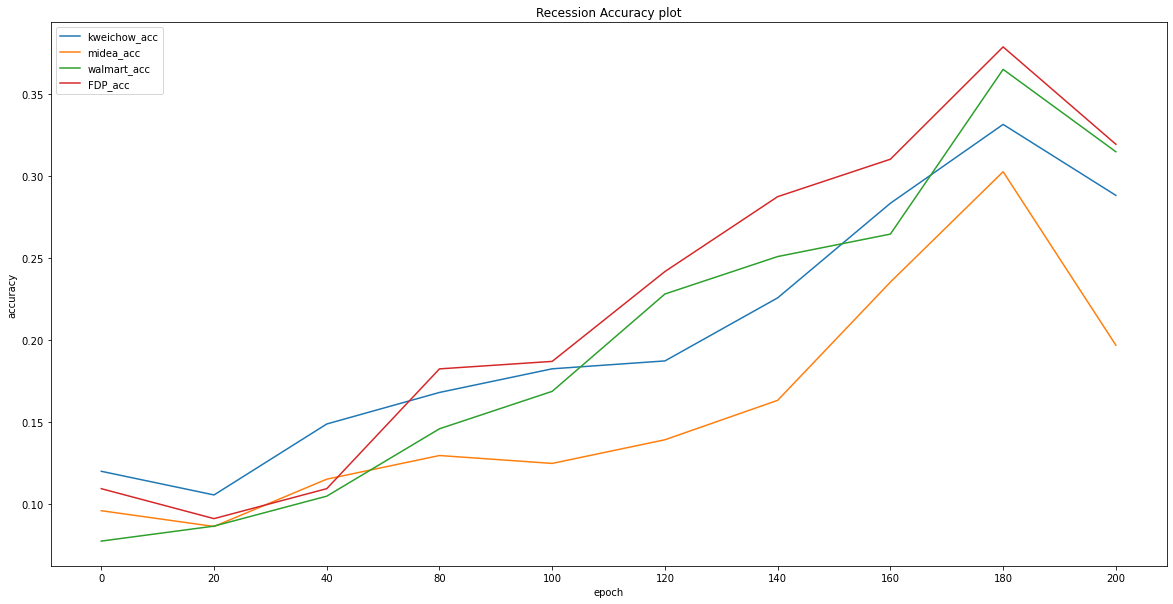

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

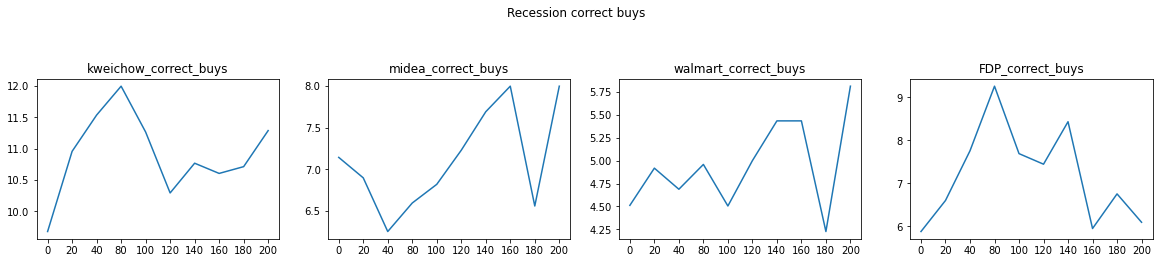

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

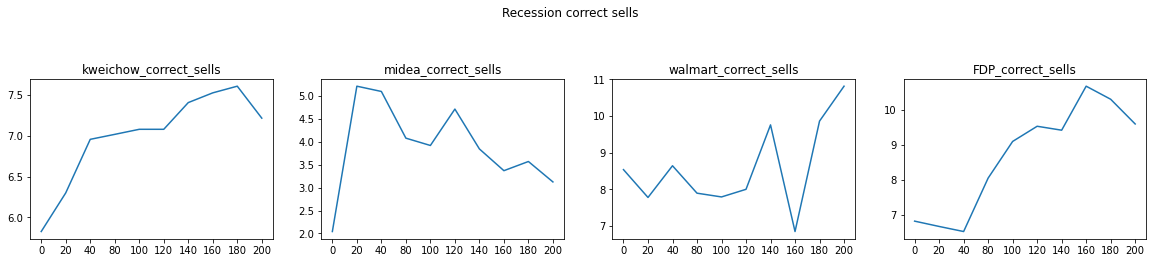

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

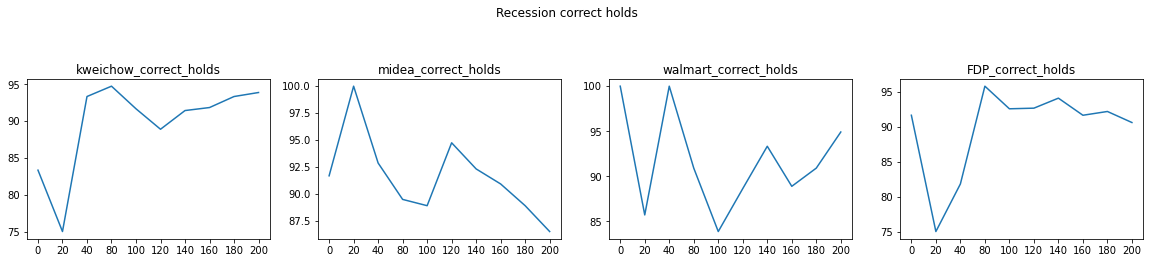

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

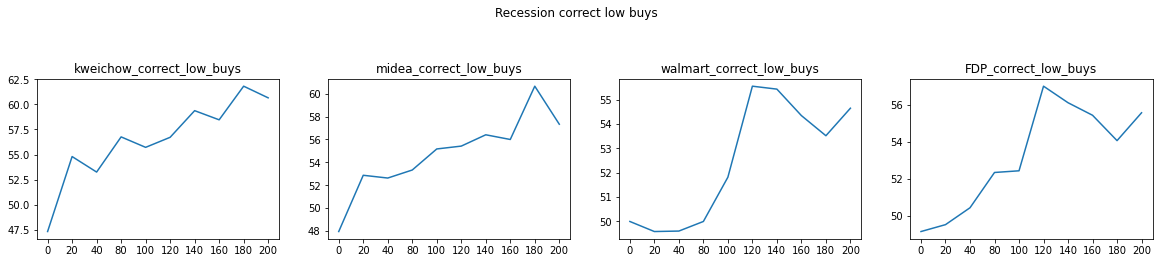

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

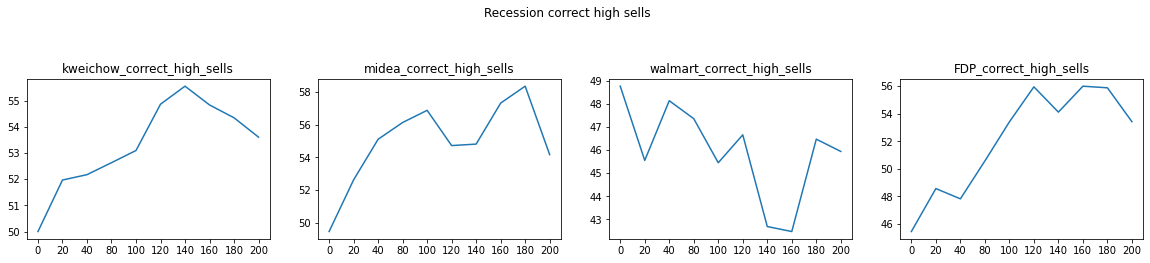

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

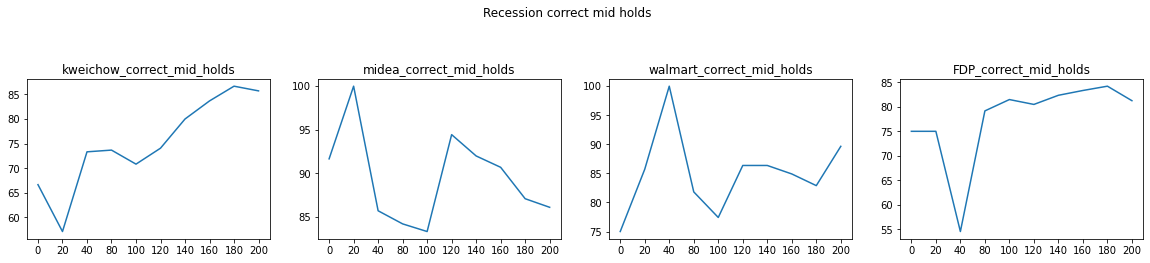

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

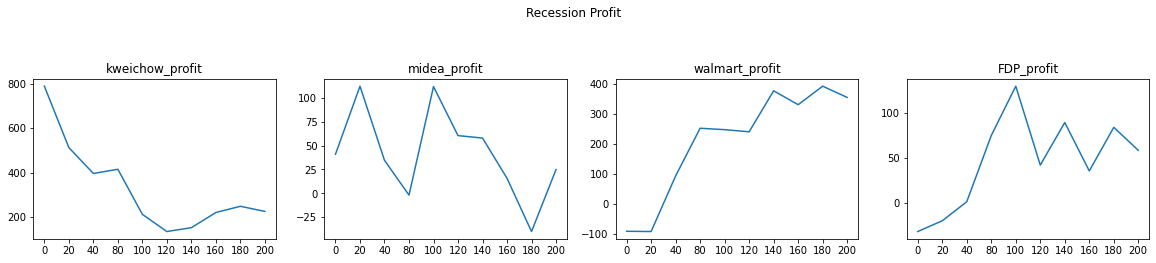

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")